In [1]:
import sys
sys.path.append('..')
import dtclib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd
import warnings
import seaborn as sns
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
torch.cuda.is_available()

ModuleNotFoundError: No module named 'dtclib'

### Creating a dataset

In [15]:
def avg_dtcs(l, m):
    """ method to average dtc vectors """
    return sum_dtcs(l, m) / len(l)

def sum_dtcs(l, m):
    """ method to sum dtc vectors """
    x = np.zeros(len(m.get_dtc_embedding('P0001')))
    for dtc in l:
        x += m.get_dtc_embedding(dtc)
    return x

def expand_dtcs(l, bd, m):
    """ Instead of merging the occuring dtcs, add them seperately to the dataset """
    X, Y = [], []
    for dtc in l:
        X.append(m.get_dtc_embedding(dtc))
        Y.append(bd)
    return X, Y


def concat_dtcs(l, m):
    """
    concatenate all dtcs for RNN purposes
    
    shape: [n_dtc, n_batch=1, embedding_shape=k (determined by dtclib feature embedding)] 
    """
    x = []
    for dtc in l:
        x.append([m.get_dtc_embedding(dtc)])
    return np.array(x)
    

def flatten_dtcs(x, y, m, method=sum_dtcs):
    """ Since multiple DTCs (or just 1) can occur for 1 type of breakdown, the dataset needs to be flattened. 
    This can be done in several ways:
    - Take the average vector of the occuring DTCs
    - Sum the vectors of the occuring DTCs
    - Expanding the dataset by adding each DTC occurrence individually
    
    Keyword arguments:
    x      -- Independent variables
    y      -- Dependent variable (or label)
    m      -- LSIModel from ANWB's own dtclib package
    method -- Method for flattening the dataset. (e.g. 'avg_dtcs', 'sum_dtcs', 'expand_dtcs' --> default = 'sum_dtcs') 
    """
    X, Y = [], []
    for l, bd in zip(x, y):
        if method == expand_dtcs:
            X_temp, Y_temp = method(l, bd, m)
            X.extend(X_temp)
            Y.extend(Y_temp)
        else:
            X.append(method(l, m))
            Y.append(bd)
            
    Y_map = {v: k for k, v in  m.BREAKDOWNS}
    Y = np.eye(len(Y_map))[list(map(lambda a: Y_map[a], Y))]
    if method == concat_dtcs:
        return X, Y, Y_map
    return np.vstack(X), Y, Y_map


Loading information and breakdown-dtc dataset from our dtclib package

In [16]:
drop = """
window spray installation
windows
A/C General
wheels and tyres general
fuel
instruments general
lighting general
steering general
fuel rail pressure sensor
starter motor
ignition coil cable
high pressure fuel pump
catalyst
engine sensors general
engine air inlet general
unknown
lcv chassis
voltage regulator/rectifier
tpms
hybrid/electric powertrain
alternator / starter motor general
boot and other accessories
igniter
heating system
motorcycle switches
drive shaft
engine cover/bottom cover
""".lower().strip().split('\n')

In [4]:
df = dtclib.load_adac()
df['bd_group'] = df['bd_group'].apply(lambda x: x.lower().strip())
df = df[~df['bd_group'].isin(drop)]
df = dtclib.get_breakdown_dtc_matrix(df)

In [5]:
m = dtclib.LSIModel(df)
del df

In [6]:
x, y = dtclib.get_breakdown_dtc_dataset()

In [7]:
y = np.array(list(map(lambda x: x.lower().strip(), y)))

In [8]:
idx = np.where(~np.isin(y, drop))[0]
x = x[idx]
y = y[idx]

In [9]:
m.BREAKDOWNS = list(map(lambda x: (x[0], x[1][1]), enumerate(filter(lambda x: x[1] not in drop, m.BREAKDOWNS))))

In [10]:
x, y, Y_map = flatten_dtcs(x, y, m, method=concat_dtcs)

In [12]:
np.random.seed(42)
i_train, i_test = next(StratifiedShuffleSplit(1, test_size=0.05).split(x, y))

In [13]:
x_train = np.array(x)[i_train]
y_train = y[i_train]
y_train = y_train.argmax(1)

x_test = np.array(x)[i_test]
y_test = y[i_test]
y_test = y_test.argmax(1)

In [37]:
def rnn_data_to_sum(x):
    return np.stack(list(map(lambda a: a.sum(0), x))).squeeze()

# Fast RNN

In [59]:
def prepare_batch(x, y):
    n_max = max([a.shape[0] for a in x])
    pad = np.zeros((n_max, len(x), x[0].shape[2]))
    
    lengths = []
    for i in range(len(x)):
        lengths.append(x[i].shape[0])
        # shape = (n-dtc, n-batch, n-features)
        pad[:x[i].shape[0], i:i + 1, :] = x[i]
        
    # mini-batch needs to be in decreasing order
    lengths = np.array(lengths)
    idx = np.argsort(lengths)[::-1]

    return pad[:, idx, :], lengths[idx], y[idx]

pad, lengths, _ = prepare_batch(x_train[:10], y_train[:10])
lengths

array([6, 3, 3, 2, 1, 1, 1, 1, 1, 1])

In [104]:
y_train

array([45, 37, 19, ..., 19, 14, 12])

In [97]:
tb = SummaryWriter('tboard/rnn_3layers_150h_sum2')

In [98]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=1)
        self.linear1 = nn.Linear(hidden_size + input_size, hidden_size + input_size)
        self.linear2 = nn.Linear(hidden_size + input_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)      
       
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)
        self.inference = False

    def forward(self, x, lengths):
        hidden = self.init_hidden(x)
        
        sum_x = x.sum(0)
        
         # pack_padded_sequence so that padded items in the sequence won't be shown the rnn
        x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths)
        x, hidden = self.rnn(x, hidden)
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x)
        
        lengths = lengths - 1
        # select only the last dtcs per breakdown (many to one)
        x = x[lengths, np.arange(x.shape[1]), :]
        
        x = torch.cat((x, sum_x), 1)        
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
#         x = F.dropout(x, 0.2, training=self.training)
        x = self.linear2(x)
        x = F.relu(x)
        x = F.dropout(x, 0.2, training=self.training)
        x = self.linear3(x)
        
        if self.inference:
            output = self.softmax(x)
        else:
            output = self.logsoftmax(x)
        return output

    def init_hidden(self, x):
        if next(self.parameters()).is_cuda:
            return torch.zeros(1, x.size(1), self.hidden_size).float().cuda()
        return torch.zeros(1, x.size(1), self.hidden_size).float()

m = RNN(x_train[0].shape[2], 150, y.shape[1])
m(torch.tensor(pad).float(), lengths).shape
# m.cuda()

torch.Size([10, 47])

In [99]:
warnings.filterwarnings(action='once')
criterion = nn.NLLLoss() #weight=torch.tensor(y_train.shape[0] / (len(np.unique(y_train)) * np.bincount(y_train)), dtype=torch.float).cuda())
optim = torch.optim.Adam(m.parameters(), lr=0.001)

epochs = 25
batch_size = 100
print_iter = 100

m.cuda()
tboard = True

m.train(True)
def get_prediction(x, y):
    pad, lengths, y = prepare_batch(x, y)
    x = torch.tensor(pad).float()
    if next(m.parameters()).is_cuda:
        x = x.cuda()
        lengths = torch.tensor(lengths).long().cuda()
    return m(x, lengths), torch.tensor(y, dtype=torch.long).cuda()

def test_eval():
    batch_pred, batch_y = get_prediction(x_test, y_test)
    batch_pred = batch_pred.cpu().data.numpy().argmax(1)
    batch_y = batch_y.cpu().data.numpy()
    return batch_pred, batch_y

idx = np.arange(x_train.shape[0])    

for epoch in range(epochs):
    
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]
        
    current_batch = 0
    for iteration in range(y.shape[0] // batch_size):
        batch_x = x_train[current_batch: current_batch + batch_size]
        batch_y = y_train[current_batch: current_batch + batch_size]
        current_batch += batch_size
                        
        optim.zero_grad()
        if len(batch_x) > 0:
            batch_pred, batch_y = get_prediction(batch_x, batch_y)
            loss = criterion(batch_pred, batch_y)
            loss.backward()
            optim.step()
            
            if tboard:
                tb.add_scalar('loss', loss.item())
            
            if iteration % print_iter == 0:
                with torch.no_grad():
                    m.train(False)
                    f1 = f1_score(batch_y.cpu().data.numpy(), batch_pred.cpu().data.numpy().argmax(1), average='weighted')
                    if tboard:
                        tb.add_scalar('f1_train', f1.item())

                    batch_pred, batch_y = test_eval()
                    f1 = f1_score(batch_y, batch_pred, average='weighted')
                    precision = precision_score(batch_y, batch_pred, average='weighted')
                    if tboard:
                        tb.add_scalar('f1', f1.item())
                        tb.add_scalar('precision', precision.item())
                    print(loss.item(), '\titeraton:', iteration, '\tepoch', epoch, 'f1', f1)
                    m.train(True)
            
            
                    
        
        

/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3.8698837757110596 	iteraton: 0 	epoch 0 f1 0.002002178509170302
3.0424325466156006 	iteraton: 100 	epoch 0 f1 0.2194708791608719
2.5239408016204834 	iteraton: 200 	epoch 0 f1 0.31235145895816774
2.324596881866455 	iteraton: 300 	epoch 0 f1 0.40969989737516654
2.2845146656036377 	iteraton: 400 	epoch 0 f1 0.4326718897600242
2.3115456104278564 	iteraton: 500 	epoch 0 f1 0.4475127616403657
1.7007012367248535 	iteraton: 600 	epoch 0 f1 0.45532204205195465
2.0239415168762207 	iteraton: 700 	epoch 0 f1 0.47110064654760636
2.1400322914123535 	iteraton: 800 	epoch 0 f1 0.4767163373048982
1.5647433996200562 	iteraton: 900 	epoch 0 f1 0.4791806849929086
1.6613084077835083 	iteraton: 1000 	epoch 0 f1 0.48276002104856425
1.9731594324111938 	iteraton: 0 	epoch 1 f1 0.4816410687124833
1.7991772890090942 	iteraton: 100 	epoch 1 f1 0.49011118507664647
1.8599865436553955 	iteraton: 200 	epoch 1 f1 0.4938813054926453
1.7883154153823853 	iteraton: 300 	epoch 1 f1 0.49299832424253376
1.6555087566375732 	

KeyboardInterrupt: 

In [357]:
f1_score(batch_y, batch_pred, average='weighted')

0.5679954224680527

In [74]:
batch_pred, batch_y = test_eval()

print(classification_report(batch_y, batch_pred, target_names=[str((k, v)) for k, v in Y_map.items()]))

                                                      precision    recall  f1-score   support

                                   ('abs system', 0)       0.61      0.65      0.63        52
                  ('brakes mechanical/hydraulic', 1)       0.26      0.27      0.27        22
            ('canbus / vehicle network / wiring', 2)       0.43      0.20      0.27       247
                         ('diesel exhaust fluid', 3)       0.06      0.80      0.11        10
                    ('diesel particulate filter', 4)       0.73      0.47      0.57       284
                                   ('esp system', 5)       0.09      0.44      0.15         9
                                    ('o2 sensor', 6)       0.56      0.75      0.64       181
                                ('parking brake', 7)       0.14      0.80      0.24         5
                        ('secundairy air system', 8)       0.21      0.67      0.32         6
                            ('airbags and seats', 9)       

In [64]:
batch_pred, batch_y = test_eval()

print(classification_report(batch_y, batch_pred, target_names=[str((k, v)) for k, v in Y_map.items()]))

                                                      precision    recall  f1-score   support

                                   ('abs system', 0)       0.63      0.65      0.64        52
                            ('airbags and seats', 1)       0.80      0.73      0.76        11
                                   ('alternator', 2)       0.26      0.24      0.25        29
                            ('automatic gearbox', 3)       0.53      0.57      0.55       108
                                      ('battery', 4)       0.46      0.25      0.32       244
                  ('brakes mechanical/hydraulic', 5)       0.39      0.41      0.40        22
                              ('camshaft sensor', 6)       0.69      0.67      0.68       183
                       ('camshaft/valve control', 7)       0.60      0.51      0.55       148
            ('canbus / vehicle network / wiring', 8)       0.37      0.40      0.38       247
                               ('clutch general', 9)       

/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
def plot_bars_f1(y_true, y_pred):
    idx = np.argsort(np.bincount(y_train))

    plt.figure(figsize=(8, 14))
    f1 = f1_score(y_true, y_pred, average=None)[idx]
    color = np.array(['b'] * len(f1))
    color[f1 < 0.25] = 'r'
    color[f1 > 0.5] = 'g'
    plt.vlines(0.5, 0, 100)
    plt.xlim(0, 1)
    plt.barh(np.array([str((k, v)) for k, v in Y_map.items()])[idx], f1, color=color)

/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<BarContainer object of 47 artists>

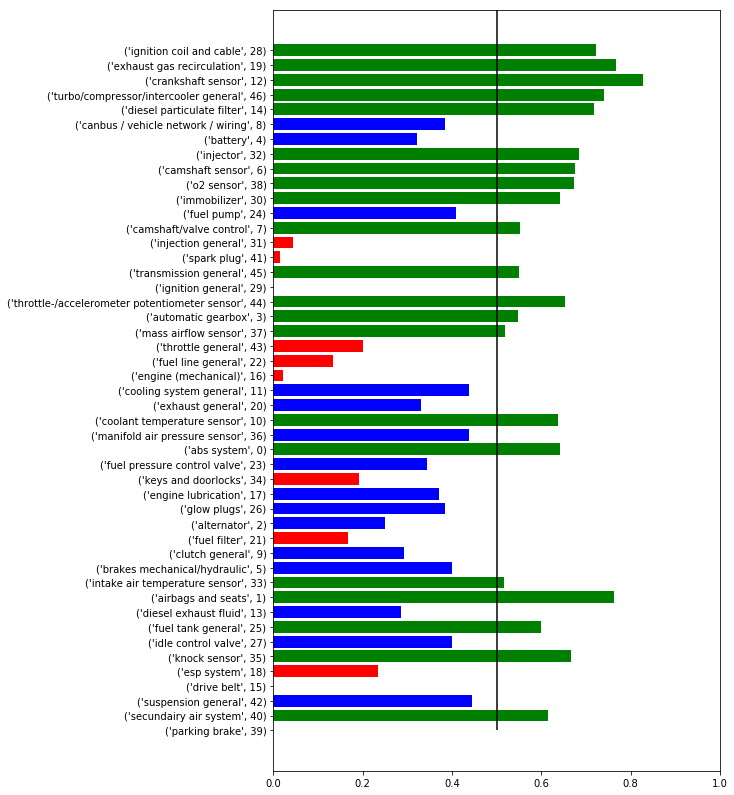

In [65]:
idx = np.argsort(np.bincount(y_train))

plt.figure(figsize=(8, 14))
f1 = f1_score(batch_y, batch_pred, average=None)[idx]
color = np.array(['b'] * len(f1))
color[f1 < 0.25] = 'r'
color[f1 > 0.5] = 'g'
plt.vlines(0.5, 0, 100)
plt.xlim(0, 1)
plt.barh(np.array([str((k, v)) for k, v in Y_map.items()])[idx], f1, color=color)

/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<BarContainer object of 47 artists>

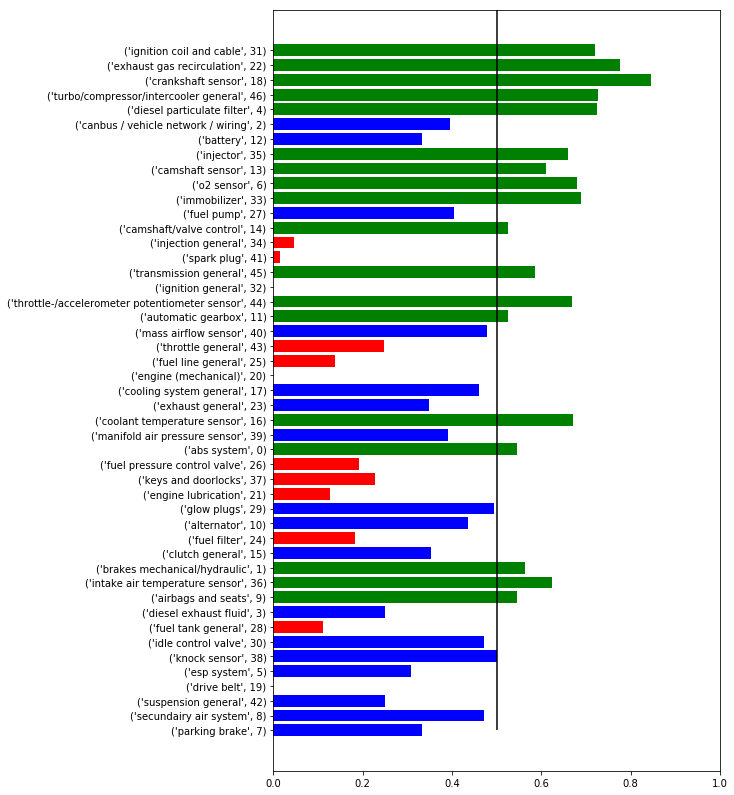

In [128]:
def plot_bars_f1(y_true, y_pred):
    idx = np.argsort(np.bincount(y_train))

    plt.figure(figsize=(8, 14))
    f1 = f1_score(y_true, y_pred, average=None)[idx]
    color = np.array(['b'] * len(f1))
    color[f1 < 0.25] = 'r'
    color[f1 > 0.5] = 'g'
    plt.vlines(0.5, 0, 100)
    plt.xlim(0, 1)
    plt.barh(np.array([str((k, v)) for k, v in Y_map.items()])[idx], f1, color=color)
    

In [131]:
torch.save(m.state_dict(), 'rnn.pt')

In [45]:
def plot_bars_f1(y_true, y_pred):
    idx = np.argsort(np.bincount(y_train))

    plt.figure(figsize=(8, 14))
    f1 = f1_score(y_true, y_pred, average=None)[idx]
    color = np.array(['b'] * len(f1))
    color[f1 < 0.25] = 'r'
    color[f1 > 0.5] = 'g'
    plt.vlines(0.5, 0, 100)
    plt.xlim(0, 1)
    plt.barh(np.array([str((k, v)) for k, v in Y_map.items()])[idx], f1, color=color)

In [103]:
for i in [10, 50, 150, 200]:
    m = GradientBoostingClassifier(n_estimators=i, random_state=12)
    m.fit(np.stack(list(map(lambda x: x.sum(0), x_train))).squeeze(), y_train)
    print('n_trees: {:40} \tf1: {}'.format(i, f1_score(y_test, m.predict(rnn_data_to_sum(x_test)), average='weighted')))

/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


n_trees:                                       10 	f1: 0.5119285818901821


KeyboardInterrupt: 

In [40]:
f1_score(y_test, m.predict(rnn_data_to_sum(x_test)), average='weighted')

/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5269225224181837

In [43]:
print(classification_report(y_test, m.predict(rnn_data_to_sum(x_test))))

             precision    recall  f1-score   support

          0       0.68      0.62      0.65        52
          1       0.54      0.64      0.58        11
          2       0.38      0.31      0.34        29
          3       0.53      0.54      0.53       108
          4       0.33      0.28      0.31       244
          5       0.47      0.36      0.41        22
          6       0.63      0.63      0.63       183
          7       0.53      0.47      0.50       148
          8       0.35      0.34      0.35       247
          9       0.39      0.26      0.31        27
         10       0.55      0.71      0.62        59
         11       0.49      0.32      0.38        76
         12       0.78      0.86      0.82       352
         13       0.22      0.20      0.21        10
         14       0.65      0.73      0.69       284
         15       0.00      0.00      0.00         8
         16       0.00      0.00      0.00        82
         17       0.38      0.26      0.31   

/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/opt/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


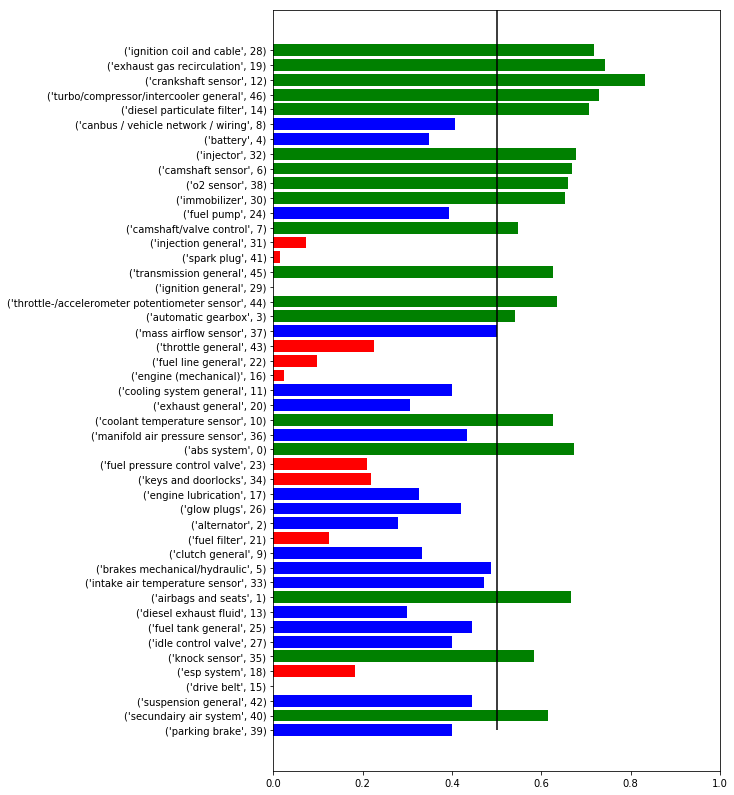

In [52]:
plot_bars_f1(y_test, m.predict(rnn_data_to_sum(x_test)))